In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
%cd /Users/bl/Dropbox/repos/Delight/
from delight.io import *
from delight.utils import *
from delight.utils_cy import approx_flux_likelihood_cy
from delight.photoz_gp import PhotozGP_SN, PhotozGP

/Users/bl/Dropbox/repos/Delight


In [2]:
# Setting style
from matplotlib import rcParams
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams['xtick.major.size'] = 2
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 2
rcParams['ytick.major.width'] = 1
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

In [3]:
%run ./scripts/processFilters.py parameter_files/parameters_SN_DES_SIM.cfg

DECAM_g DECAM_r DECAM_i DECAM_z DECAM_y 

In [4]:
# Now we load the parameter file and the useful quantities
params = parseParamFile('parameter_files/parameters_SN_DES_SIM.cfg', verbose=False)
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms\
    = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)

In [5]:
fname = 'SN_DES_SIM/DES_BLIND+HOSTZ/DES_SN199986 copy.DAT'
data = np.genfromtxt(fname, dtype='f8, |S1, |S4, f8, f8', delimiter='')
bands = [b'g', b'r', b'i', b'z']
X = np.zeros((data.size, 4))
Y = np.zeros((data.size, 1))
Yvar = np.zeros((data.size, 1))
specz = 0.6309 
DL = approx_DL()
ell = ((np.pi * 4 * DL(specz)**2 ) / (1.+specz))**2
print(ell)
for i, dat in enumerate(data):
    X[i, 0] = bands.index(dat[1]) # band
    X[i, 1] = specz # z
    X[i, 2] = ell # ell
    X[i, 3] = dat[0] # time
    Y[i, 0] = dat[3] # fl
    Yvar[i, 0] = dat[4]**2. # fl err
X[:, 3] -= X[:, 3].min()
X[:, 3] /= X[:, 3].max()

1.24015527436e+16


In [15]:
params['V_C'], params['V_L'] = 1e-4, 0
params['alpha_T'], params['alpha_C'], params['alpha_L'] = 1e2, 1e18, 1e2
gp = PhotozGP_SN(
    bandCoefAmplitudes, bandCoefPositions, bandCoefWidths,
    params['lines_pos'], params['lines_width'], params['V_C'], params['V_L'],
    params['alpha_T'], params['alpha_C'], params['alpha_L'],
    redshiftGridGP, use_interpolators=False)

In [16]:
params['V_C'], params['V_L'] = 1e-4, 0
params['alpha_T'], params['alpha_C'], params['alpha_L'] = 1e2, 1e3, 1e2
DL = approx_DL()
gp = PhotozGP_SN(
    bandCoefAmplitudes, bandCoefPositions, bandCoefWidths,
    params['lines_pos'], params['lines_width'], params['V_C'], params['V_L'],
    params['alpha_T'], params['alpha_C'], params['alpha_L'],
    redshiftGridGP, use_interpolators=False)

In [17]:
from scipy.optimize import minimize

unused_band = 1
ind = X[:, 0].astype(int) != unused_band
#ind &= Y[:, 0].astype(int) > 0
gp.setData(X[ind, :], Y[ind, :], Yvar[ind, :])

In [18]:
import scipy.linalg
def fun(params):
    gp.kernel.alpha_T = params[0]
    gp.kernel.alpha_C, gp.kernel.alpha_L = params[1], 1e1
    gp.kernel.V_C, gp.kernel.V_L = params[2], 0
    gp.KXX = gp.kernel.K(gp.X)
    gp.A = gp.KXX + np.diag(gp.Yvar.flatten())
    sign, gp.logdet = np.linalg.slogdet(gp.A)
    gp.logdet *= sign
    gp.L = scipy.linalg.cholesky(gp.A, lower=True)
    gp.D = 1*gp.Y
    gp.beta = scipy.linalg.cho_solve((gp.L, True), gp.D)
    v = -gp.margLike()
    #print(params, v)
    return v
fun([5e0, 1e6, 1e-4])

-194.5257253042264

In [19]:
res = minimize(fun, [5e0, 1e6, 1e-4], bounds=[[1e-2, 1e2], [1e0, 1e12], [1e-10, 1e6]], method='SLSQP')
print(res)

params = res.x
gp.kernel.alpha_T = params[0]
gp.kernel.alpha_C, gp.kernel.alpha_L = params[1], 1e1
gp.kernel.V_C, gp.kernel.V_L = params[2], 0

     fun: -194.08536353189976
     jac: array([-1111.84673309, -9661.49345779,     0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 181
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([  5.27705415e+00,   9.99971539e+05,   1.00000000e-04])


/Users/bl/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


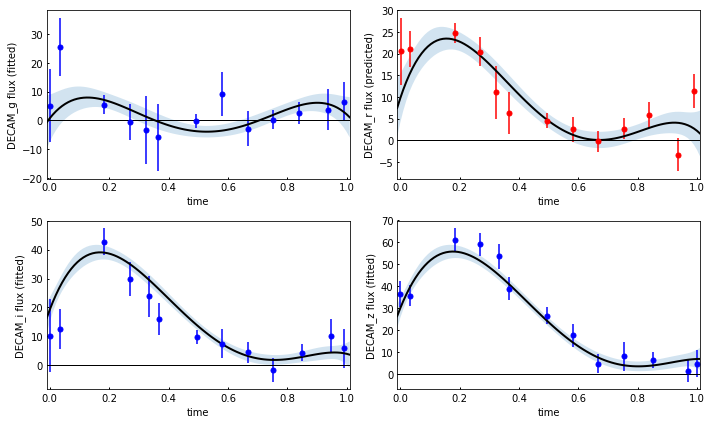

In [20]:
xmin, xmax = -0.01, 1.01
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs = axs.ravel()
for ib, b in enumerate(bands):
    ind = X[:, 0].astype(int) == ib
    #ind &= Y[:, 0] > 0
    if ib == unused_band:
        c = 'r'
        txt = '(predicted)'
    else:
        c = 'b'
        txt = '(fitted)'
    axs[ib].errorbar(X[ind, 3], Y[ind, 0], Yvar[ind, 0]**0.5, fmt="o", markersize=5, c=c)
    nd = 100
    x_pred = np.zeros((nd, 4))
    x_pred[:, 0] = ib # band
    x_pred[:, 1] = specz # z
    x_pred[:, 2] = ell # ell
    x_pred[:, 3] = np.linspace(xmin, xmax, nd) # time
    y_pred, y_pred_cov = gp.predict(x_pred, diag=True)
    y_pred = y_pred.ravel()
    y_pred_sig = y_pred_cov.ravel()**0.5
    #y_pred_sig = (np.diag(y_pred_cov)**0.5).ravel()
    axs[ib].plot(x_pred[:, 3], y_pred[:], lw=2, c='k')
    axs[ib].plot(x_pred[:, 3], 0*y_pred[:], lw=1, c='k')
    axs[ib].fill_between(x_pred[:, 3], y_pred + y_pred_sig, y_pred - y_pred_sig, alpha=0.2)
    axs[ib].set_xlim([xmin, xmax])
    axs[ib].set_ylabel(bandNames[ib]+' flux '+txt)
    axs[ib].set_xlabel('time')
    
fig.tight_layout()